In [2]:
# Cell 1: pin TF and NumPy, force-reinstall into this kernel
%pip install --upgrade pip
%pip install --upgrade --force-reinstall tensorflow==2.16.1 numpy==1.24.3 matplotlib



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 197.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 158.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 159.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 139.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 167.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 143.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 153.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.5 MB/s eta 0:00

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

print(np.__version__, tf.__version__)  # e.g. 1.24.3 2.16.1


2.0.2 2.18.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')        # follow link → paste auth code

DRIVE = "/content/drive/MyDrive"
!ls -lh $DRIVE | grep '.npy\|scaler.pkl'   # quick sanity listing


Mounted at /content/drive
-rw------- 1 root root 1.1K Jun 29 23:20 scaler.pkl
-rw------- 1 root root 7.7M Jun 29 23:20 train.npy
-rw------- 1 root root 2.0M Jun 29 23:20 val.npy
-rw------- 1 root root  24K Jun 29 23:19 y_train.npy
-rw------- 1 root root 6.1K Jun 29 23:20 y_val.npy


In [3]:
X_train = np.load(f"{DRIVE}/train.npy")    # (3045, 30, 11)
y_train = np.load(f"{DRIVE}/y_train.npy")  # (3045,)
X_val   = np.load(f"{DRIVE}/val.npy")      # (760, 30, 11)
y_val   = np.load(f"{DRIVE}/y_val.npy")    # (760,)

print("Shapes →", X_train.shape, y_train.shape, X_val.shape, y_val.shape)


Shapes → (3045, 30, 11) (3045,) (760, 30, 11) (760,)


In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(32, dropout=0.1),   # 32 hidden units, 10 % dropout
        input_shape=X_train.shape[1:]
    ),
    tf.keras.layers.Dense(1)                    # predict next-day gold (scaled)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 64)             │         8,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,705 (34.00 KB)

 Trainable params: 8,705 (34.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es],
    verbose=1)


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0177 - mae: 0.0969 - val_loss: 0.0078 - val_mae: 0.0588
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 0.0064 - val_mae: 0.0537
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.5342e-04 - mae: 0.0225 - val_loss: 0.0043 - val_mae: 0.0494
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.1899e-04 - mae: 0.0215 - val_loss: 0.0056 - val_mae: 0.0487
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.4860e-04 - mae: 0.0215 - val_loss: 0.0067 - val_mae: 0.0531
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.2829e-04 - mae: 0.0207 - val_loss: 0.0078 - val_mae: 0.0616


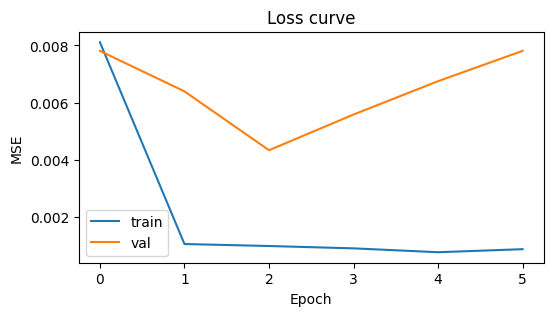

In [6]:
plt.figure(figsize=(6,3))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.title("Loss curve")
plt.show()


In [10]:
# 1. Save the trained model
MODEL_PATH = f"{DRIVE}/bgru_model.keras"
model.save(MODEL_PATH)           # ✅ works
print("Model saved to", MODEL_PATH)

# 2. Make val-set predictions & save CSV
val_pred = model.predict(X_val, verbose=0).squeeze()
np.savetxt(f"{DRIVE}/pred_bi_gru.csv", val_pred,
           delimiter=",", header="pred_bi_gru", comments="")
print("Validation predictions saved → pred_bi_gru.csv")


Model saved to /content/drive/MyDrive/bgru_model.keras
Validation predictions saved → pred_bi_gru.csv


In [11]:
scaler = pickle.load(open(f"{DRIVE}/scaler.pkl", "rb"))
gold_idx = list(scaler.feature_names_in_).index("GC=F")   # ticker column index

def unscale(val):
    vmin, vmax = scaler.data_min_[gold_idx], scaler.data_max_[gold_idx]
    return val * (vmax - vmin) + vmin

val_pred_real = np.vectorize(unscale)(val_pred)
print("First 5 real-currency preds:", val_pred_real[:5])


First 5 real-currency preds: [1830.2463425  2075.84890061 2050.5898538  2036.99611282 2020.73076754]


In [12]:
rmse = np.sqrt(np.mean((val_pred - y_val)**2))
print("Validation RMSE (scaled):", rmse)

Validation RMSE (scaled): 0.0674593360079881
